In [1]:
import scipy as sp
import scipy.optimize as op
import numpy as np
import pylab as pl
import emcee
from lmfit.models import SkewedGaussianModel

I'm modelling the spectral lines as skewed Gaussians. I can't be bothered to code up a skewed Gaussian myself, so I'm using the predefined function from the lmfit library: https://lmfit.github.io/lmfit-py/builtin_models.html#skewedgaussianmodel

$$
\frac{A}{\sigma \sqrt{2\pi}}{\rm e}^{-(x-\mu)^2/2\sigma^2}\left\{1+{\rm erf}\left[\frac{\gamma(x-\mu)}{\sigma\sqrt{2}}\right]\right\}
$$

This has four free parameters: the amplitude, $A$; the mean position, $\mu$; the width, $\sigma$; and the skew, $\gamma$. It's the values of those parameters that we'll be fitting for.

In [2]:
def gauss_fn(p0, x):
    
    # extract parameters from p0 array:
    amp,mu,sigma,gamma = p0
    
    # initiate model:
    model = SkewedGaussianModel()

    # set initial parameter values
    params = model.make_params(amplitude=amp, center=mu, sigma=sigma, gamma=gamma)
    
    # evaluate model at x-positions:
    ymod = model.eval(params=params,x=x)
    
    return ymod

I'm going to define the parameters of my simulated line:

In [3]:
amp = 5000.
mu = 300.
sigma = 30.
gamma = -3.

p0 = np.array([amp,mu,sigma,gamma])

Now I'll simulate the line at a range of x-positions:

In [4]:
xvals = np.arange(0,500,1)
yvals = gauss_fn(p0,xvals)

I've simulated the underlying model, but now I need to simulate the *measured* data, which means giving it some Poisson scatter:

In [5]:
ymeas = np.random.poisson(yvals)

Let's plot it up and see how it looks:

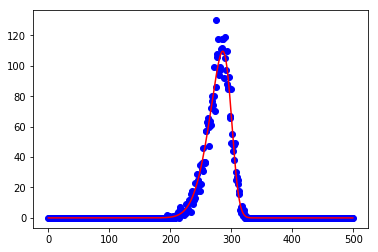

In [6]:
pl.subplot(111)
pl.scatter(xvals,ymeas,c='b')
pl.plot(xvals,yvals,c='r')
pl.show()

---

Now let's try and fit the pretend data to recover the input parameters. The data have Poisson noise, so we need a Poisson loglikelihood.

*Note: the $\chi^2$ function is a Gaussian loglikelihood*

The Poisson probability density function looks like this:

$$
\frac{\lambda^x {\rm e}^{-\lambda}}{x!}
$$

so the loglikelihood looks like this:

$$
\log \left( \frac{\lambda^x {\rm e}^{-\lambda}}{x!} \right) 
$$

$$
= \log \lambda^x + \log {\rm e}^{-\lambda} - \log x!
$$

$$
= x\log \lambda - \lambda - \left\{x\log (x) - x  \right\}
$$

where I have used the Stirling approximation for the factorial in the final term.

You can also find this here: https://www.statlect.com/fundamentals-of-statistics/Poisson-distribution-maximum-likelihood

In [7]:
def lnlike(p0, x, y):
    
    # get model for these parameters:
    ymod = gauss_fn(p0,x)
    
    # Poisson loglikelihood:
    ll = np.sum(ymod[np.where(ymeas!=0)]*np.log(ymeas[np.where(ymeas!=0)])) - np.sum(ymeas) - np.sum(ymod[np.where(ymod!=0)]*np.log(ymod[np.where(ymod!=0)]) - ymod[np.where(ymod!=0)])
    
    return ll

First off we're going to use direct optimisation using scipy. This requires the **negative** loglikelihood function, so we need to define that:

In [8]:
nll = lambda *args: -lnlike(*args)

We then need to define a starting guess for our parameters:

In [9]:
p0 = np.array([5000,300,10,-5])

and some boundaries for the range of parameters:

In [10]:
bnds = ((-np.infty,np.infty), (-np.infty,np.infty), (0.1,np.infty), (-10., 10.))

...and let's fit:

In [11]:
result = op.minimize(nll, p0, bounds=bnds, args=(xvals, ymeas))

Now let's print the best fit parameters:

In [12]:
p1 = result["x"]
print p1

[ 4.87594268e+03  2.99610059e+02  2.95002849e+01 -2.78099204e+00]


...and plot our fitted model over our data to see how it looks:

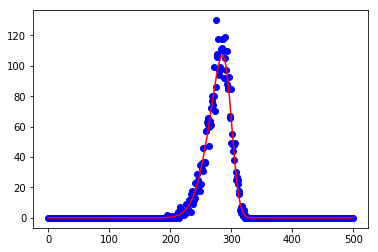

In [13]:
yfit = gauss_fn(p1,xvals)
pl.subplot(111)
pl.scatter(xvals,ymeas,c='b')
pl.plot(xvals,yfit,c='r')
pl.show()

Let's look at the residuals:

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in divide
  """Entry point for launching an IPython kernel.
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in divide
  """Entry point for launching an IPython kernel.


Text(0,0.5,'$\\sigma$')

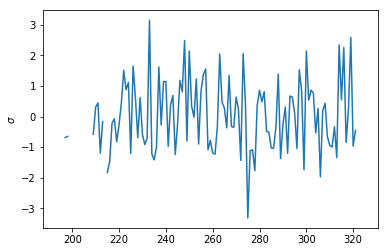

In [21]:
res = (yfit - ymeas)/np.sqrt(ymeas)
pl.plot(res)
pl.ylabel(r"$\sigma$")

ok, these look pretty sensible (i.e. distributed symmetrically around zero and almost all within 3 sigma).

---

We can also use Markov Chain Monte Carlo (MCMC) fitting to see what the likelihood space looks like.

*Note: this is a very simple MCMC and wouldn't be suitable for a publication.*

In [14]:
ndim, nwalkers = 4, 100
pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

In [15]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnlike, args=(xvals, ymeas))

In [16]:
p0 = sampler.run_mcmc(pos, 500)

In [17]:
samples = sampler.chain[:, 50:, :].reshape((-1, ndim))

IndexError: list index out of range

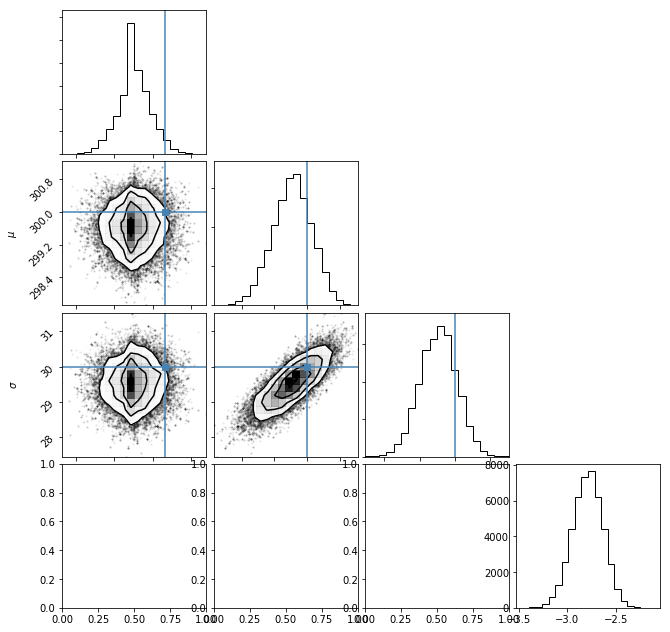

In [18]:
import corner
fig = corner.corner(samples, labels=["$A$", "$\mu$", "$\sigma$"],
                      truths=[amp, mu, sigma])
fig.savefig("triangle.png")